### Import paczek

In [40]:
include("utils/GlobalUsings.jl")
include("utils/DataLoader.jl")
include("Lib/CustomDiffLib.jl")
include("utils/NetFunctions.jl")
include("utils/Ploter.jl")

plotTestAccuracty (generic function with 1 method)

##  Załadowanie danych

In [41]:
X_train, y_train, X_test, y_test, classes  = getPrepearedData()
nothing

## SIEĆ FLUX

In [42]:
include("nets/netFlux.jl")
fluxNet, opt, loss, params = getDefaultFlux(4)
fluxLossHistory, fluxAccuracyTrainingHistory = train(fluxNet, params, X_train, y_train, 5, opt, loss)
fluxAccuracyTrainingVal = getTrainingAccValFromHistory(fluxAccuracyTrainingHistory)
fluxAccuracyTestHistory, fluxAccuracyTestVal = getFluxAccuracyValFromTest(fluxNet, X_test, y_test)
nothing

#### Wykresy 

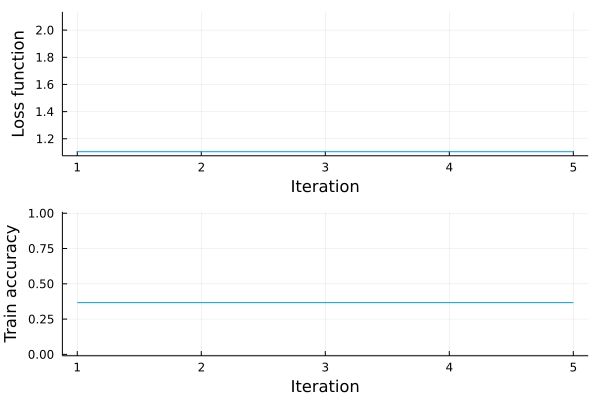

In [43]:
plotLossAccuracy(fluxLossHistory, fluxAccuracyTrainingHistory)

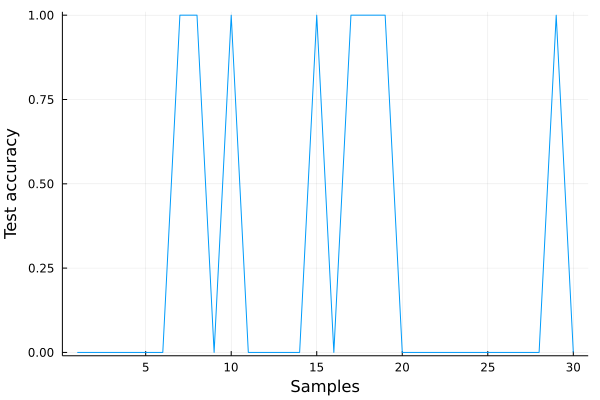

In [44]:
plotTestAccuracty(fluxAccuracyTestHistory)

### Sieć Ani

In [45]:
include("nets/NetAnia.jl")
aniaNet = getDefaultAniaNet(4)
aniaLossHistory, AniaAccHistory = trainAnia(aniaNet, X_train, y_train, 5, 0.01)
aniaAccTrainVal = getTrainingAccValFromHistory(AniaAccHistory)
acc_history, AniaTestAccVal = accuracy(aniaNet, X_test, y_test)
nothing

MethodError: MethodError: no method matching mean_squared_loss(::BitVector, ::Vector{Float64})
Closest candidates are:
  mean_squared_loss(!Matched::Vector, ::Vector) at e:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\utils\NetFunctions.jl:14

### Wykresy

In [46]:
plotLossAccuracy(aniaLossHistory, AniaAccHistory)

UndefVarError: UndefVarError: aniaLossHistory not defined

In [47]:
plotTestAccuracty(acc_history)

UndefVarError: UndefVarError: acc_history not defined

## Sieć Sebastiana

In [48]:
include("nets/netSebastian.jl")
sebastianNet = getSebastianDefaultNet(4)
sebastianTrainLoss, sebastianTrainAccHistory = trainSebastian(sebastianNet, X_train, y_train, 5, 0.01)

sebastianTrainAccVal = getTrainingAccValFromHistory(sebastianTrainAccHistory)
sebastianTestAccuracy, sebastianTestAccVal = accuracySebastian(sebastianNet, X_test, y_test)
nothing


MethodError: MethodError: no method matching mean_squared_loss(::BitVector, ::Vector{Float64})
Closest candidates are:
  mean_squared_loss(!Matched::Vector, ::Vector) at e:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\utils\NetFunctions.jl:14

### Wykresy

In [49]:
plotLossAccuracy(sebastianTrainLoss, sebastianTrainAccHistory)

UndefVarError: UndefVarError: sebastianTrainLoss not defined

In [50]:
plotTestAccuracty(sebastianTestAccuracy)

UndefVarError: UndefVarError: sebastianTestAccuracuy not defined

In [51]:
df_learning_results = DataFrame(Net=String[], TestAccuracy=Float64[], TrainAccuracy=Float64[], LossFunctionMinimum=Float64[], LossFunctionMaximum=Float64[],LossFunctionStd=Float64[] )
push!(df_learning_results, ("Flux", fluxAccuracyTestVal, fluxAccuracyTrainingVal, minimum(fluxLossHistory), maximum(fluxLossHistory), std(fluxLossHistory)))
push!(df_learning_results, ("Ania", AniaTestAccVal, aniaAccTrainVal, minimum(aniaLossHistory), maximum(aniaLossHistory), std(aniaLossHistory)))
push!(df_learning_results, ("Sebastian", sebastianTestAccVal, sebastianTrainAccVal, minimum(sebastianTrainLoss), maximum(sebastianTrainLoss), std(sebastianTrainLoss)))
println("HIDDEN LAYERS:",3)
print(df_learning_results)

UndefVarError: UndefVarError: aniaLossHistory not defined

In [52]:
using BenchmarkTools
t = @benchmark trainSebastian(sebastianNet, X_train, y_train, 5, 0.01)

MethodError: MethodError: no method matching mean_squared_loss(::BitVector, ::Vector{Float64})
Closest candidates are:
  mean_squared_loss(!Matched::Vector, ::Vector) at e:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\utils\NetFunctions.jl:14